In [1]:
import pandas as pd
import numpy as np
import scipy
import xarray as xr
import dask 

import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
matplotlib.rcParams['font.family'] = 'sans-serif'

matplotlib.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans',
                               'Lucida Grande', 'Verdana']


/Users/justinsimcock/miniconda3/envs/dawp/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/Users/justinsimcock/miniconda3/envs/dawp/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [38]:
fx_data_path= '/'
eur_usd = pd.read_csv(fx_data,header=None, names=['date', 'open', 'high', 'low', 'close', 'volume'])
eur_usd.head()

,date,open,high,low,close,volume
0,19990101,1.1661,1.1740,1.1644,1.1736,0
1,19990104,1.1799,1.1850,1.1773,1.1812,0
2,19990105,1.1750,1.1899,1.1740,1.1811,0
3,19990106,1.1811,1.1835,1.1741,1.1759,0
4,19990107,1.1759,1.1784,1.1561,1.1632,0


In [42]:
eur_usd['date'] = pd.to_datetime(eur_usd.date, format='%Y%m%d')
eur_usd['month'] = eur_usd.date.dt.month
eur_usd['year'] = eur_usd.date.dt.year
eur_usd['day_of_year'] = eur_usd.date.dt.dayofyear
eur_usd['weekday'] = eur_usd.date.dt.dayofweek
eur_usd['days_till_month_end'] = eur_usd.date.dt.days_in_month - eur_usd.date.dt.day
eur_usd['log_ret'] = np.log(eur_usd.close) - np.log(eur_usd.close.shift(1))

In [99]:
eur_usd.head()

,date,open,high,low,close,volume,month,year,day_of_year,weekday,days_till_month_end,log_ret
0,1999-01-01,1.1661,1.1740,1.1644,1.1736,0,1,1999,1,4,30,NaN
1,1999-01-04,1.1799,1.1850,1.1773,1.1812,0,1,1999,4,0,27,0.006455
2,1999-01-05,1.1750,1.1899,1.1740,1.1811,0,1,1999,5,1,26,-0.000085
3,1999-01-06,1.1811,1.1835,1.1741,1.1759,0,1,1999,6,2,25,-0.004412
4,1999-01-07,1.1759,1.1784,1.1561,1.1632,0,1,1999,7,3,24,-0.010859


In [65]:
eur_usd.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'month', 'year',
       'day_of_year', 'weekday', 'days_till_month_end', 'log_ret'],
      dtype='object')

In [57]:
monthly_returns = eur_usd.groupby(['month', 'year']).sum().groupby(level=[0]).cumsum()['log_ret']

In [61]:
mr_xr = monthly_returns.to_xarray()

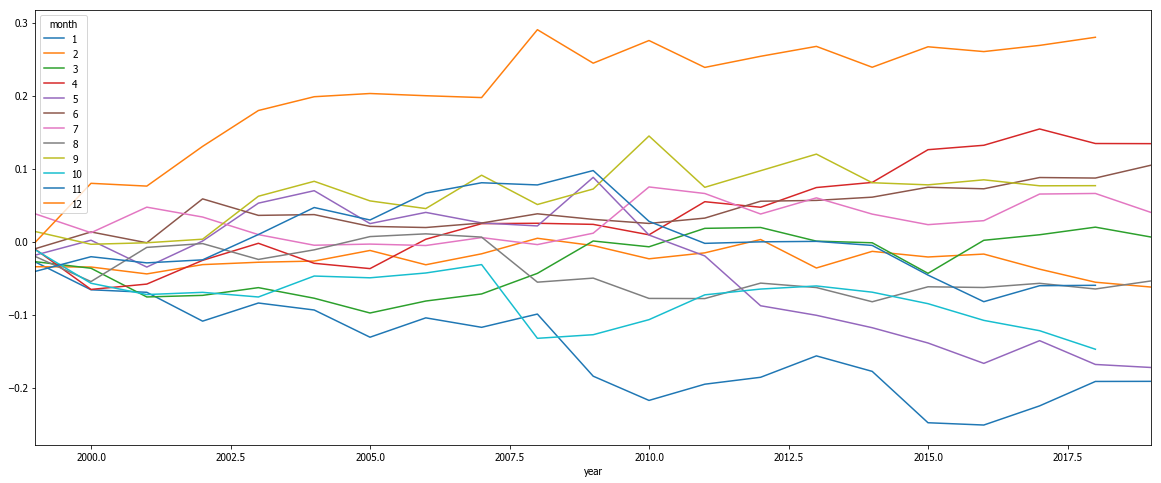

In [64]:
monthly_returns.unstack(level=0).plot(kind='line', subplots=False, figsize=(20,8));

In [72]:
day_of_week_returns = eur_usd.groupby(['weekday', 'year']).sum().groupby(level=[0]).cumsum()['log_ret']

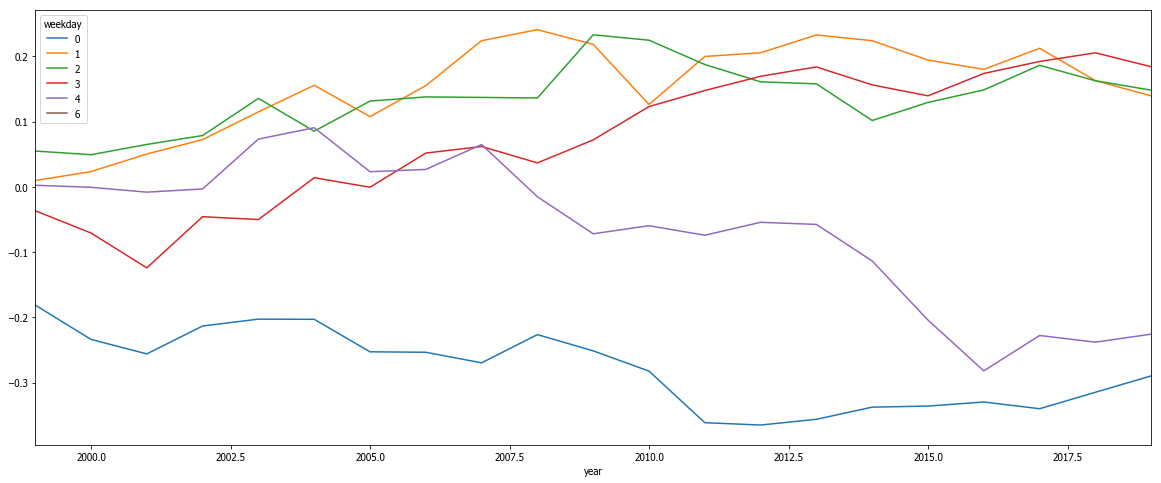

In [73]:
day_of_week_returns.unstack(level=0).plot(kind='line', subplots=False, figsize=(20,8));

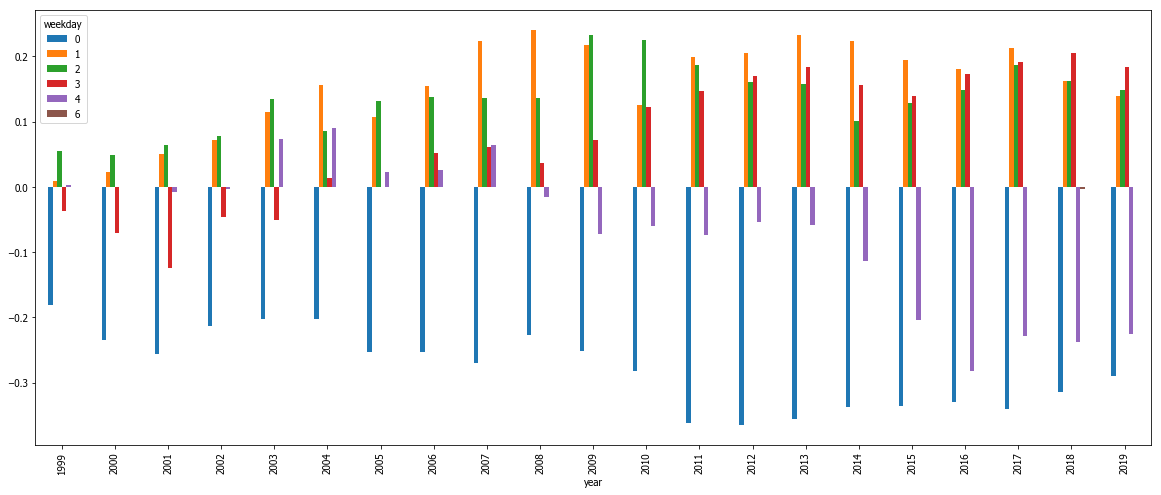

In [68]:
daily_returns.unstack(level=0).plot(kind='bar', subplots=False, figsize=(20,8));

In [74]:
days_till_month_end = eur_usd.groupby(['days_till_month_end', 'year']).sum().groupby(level=[0]).cumsum()['log_ret']

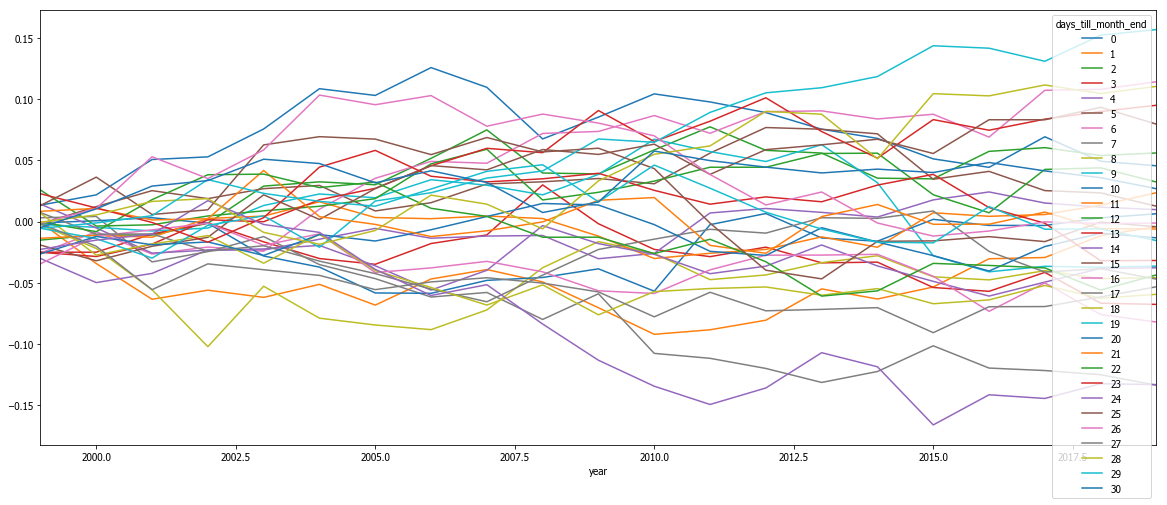

In [78]:
days_till_month_end.unstack(level=0).plot(kind='line', subplots=False, figsize=(20,8));

In [85]:
days_till_month_end_xr = days_till_month_end.to_xarray()

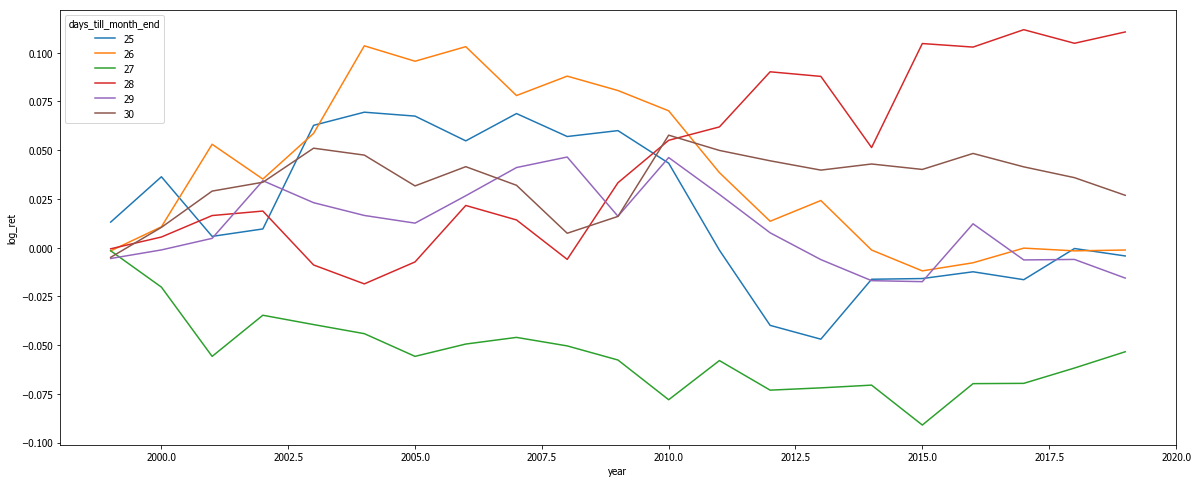

In [97]:
days_till_month_end_xr.sel(days_till_month_end=slice(25,31)).plot.line(x='year', figsize=(20,8));

In [102]:
fx_data_path= '/Users/justinsimcock/Resilio Sync/FXBootcamp/Daily/'

def fx_io(currency_pair, fx_data_path=fx_data_path):
    '''
    Given a path and currency pair string opens csv file into pd.Dataframe
    Performs basic data manipulation like column assignment and datetime conversion
    
    Parameters
    ==========
    currency_pair: str in form `EURUSD`, `USDJPY`...
    fx_data_path: str points to location of directory/file on local/remote disk
    
    Returns
    =======
    pd.Dataframe
    '''
    
    ts = pd.read_csv(fx_data_path + currency_pair + '.csv', 
                    header=None, 
                    names=['date', 'open', 'high', 'low', 'close', 'volume'])
    ts['date'] = pd.to_datetime(ts.date, format='%Y%m%d')
    
    return ts
    

def seasonality_transform(ts):
    '''
    Computes daily-log returns for a financial time series 
    as well as creating categorical time dimension columns 
    used for seasonality analysis
    
    Parameters
    ==========
    ts: pd.Dataframe
    
    Returns
    =======
    pd.Dataframe
    '''
    
    ts['month'] = ts.date.dt.month
    ts['year'] = ts.date.dt.year
    ts['day_of_year'] = ts.date.dt.dayofyear
    ts['weekday'] = ts.date.dt.dayofweek
    ts['days_till_month_end'] = ts.date.dt.days_in_month - ts.date.dt.day
    ts['log_ret'] = np.log(ts.close) - np.log(ts.close.shift(1))
    
    return ts
    

In [103]:
ts = fx_io('EURUSD')

In [105]:
ts = seasonality_transform(ts)

In [110]:
def visualize_ts(ts, dimension):
    
    ts_xr = ts.groupby([dimension, 'year']).sum().groupby(level=[0]).cumsum()['log_ret'].to_xarray()
    plt = ts_xr.plot.line(x='year', figsize=(20,8));
    return plt

### Monthly Returns

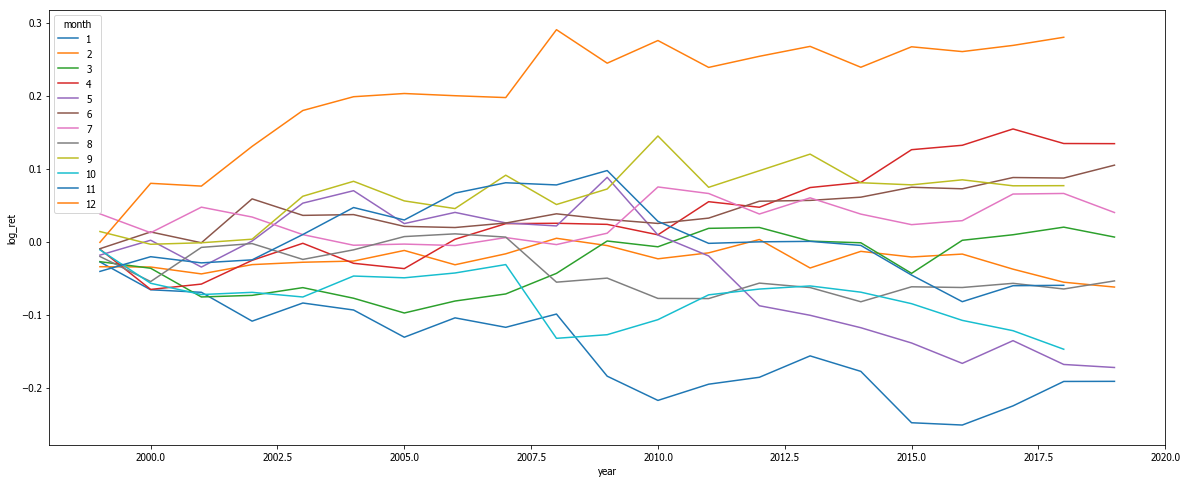

In [112]:
visualize_ts(ts, 'month');